## Cardiac MRI Segmentation
This notebook was written to train an image segmentation model for cardiac images. See question.pdf for more details about data and problem. We use pretrained U-Net segmentation model to solve this problem in Pytorch.

The cell below shows an example of the given data. The segmentation has 4 classes, including the background.

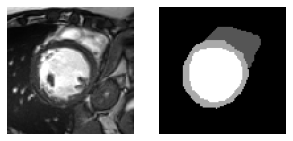

True

In [7]:
from matplotlib import pyplot as plt
import os
import cv2 #import OpenCV

def show_image_mask_mask(img, mask,out, cmap='gray'): # function shows image and 2 masks 
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 3, 1,label='image')
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    
    plt.subplot(1, 3, 2,label='mask')
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 3, 3,label='predicted mask')
    plt.imshow(out, cmap=cmap)
    plt.axis('off')

def show_image_mask(img, mask, cmap='gray'): # known function that shows an image and a mask
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')


data_dir = './data/train'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
#print(image.shape,mask.shape)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)

The next cell defines the dataloaders along with the data augmentation pipeline using albumentations library.

In [8]:
from torch.utils.data import DataLoader
import torch,numpy as np
import torch.utils.data as data
import cv2
import os
from glob import glob
import albumentations as A

transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5,border_mode=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    
])

class TrainDataset(data.Dataset):
    def __init__(self, root=''):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            transformed =  transform(image=data,mask=label)
            return torch.from_numpy(np.expand_dims(transformed['image'],axis=0)).float(), torch.from_numpy(transformed['mask']).float()

    def __len__(self):
        return len(self.img_files)
    
    
class ValDataset(data.Dataset):
    def __init__(self, root=''):
        super(ValDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            
            return torch.from_numpy(np.expand_dims(data,axis=0)).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)
    
class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = np.expand_dims(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), axis=0)
            return torch.from_numpy(data).float() , img_path

    def __len__(self):
        return len(self.img_files)

The next cell defines the model, which is built using a pre-trained model library - [segmentation_models_pytorch](https://github.com/qubvel/segmentation_models.pytorch). The model is UNet with efficientnet-b4 encoder and imagenet pre-trained weights

In [9]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b4",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

This next cell contains the main training loop. The loss fucntion used is also taken from the smp library where the model comes from. The loss function is a log-based multiclass dice loss. It gives better training performance as compared to the vanilla CrossEntropy loss of nn module, which stagnates after a point. We use the Adam optimizer.

In [10]:
import time
import segmentation_models_pytorch as smp

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

#model=torch.load('u-effb4_100.pth')
model.to(device)

epochs = 3  #50
data_path = './data/train'
num_workers = 4
batch_size = 5
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

loss_fn = torch.nn.CrossEntropyLoss()
loss_fn_2 = smp.losses.DiceLoss('multiclass', classes=None, log_loss=True, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-07)
train_loss=[]

model.train()
#opt_sgd = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=0.0008)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min')

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for image,mask in training_data_loader:
        #print(image.shape,mask.shape)
        image.to(device)
        mask.to(device)
        image = image.to(device)
        mask = mask.to(device)
        
        out = model(image)
        loss = loss_fn_2(out,mask.long())
        opt.zero_grad()
        loss.backward()
        opt.step()

        # print statistics - epoch and loss
        running_loss += loss.item()
        print(loss.item())
        
        
    train_loss.append(running_loss)
    print(running_loss,' - loss for epoch: ',epoch)
    time.sleep(10)
    if epoch%10 == 0:
        torch.save(model,'u-effb4_chckpnt.pth')
    
        
print('Finished Training')
torch.save(model,'u-effb4_100.pth')

The current device is cuda:0
1.9331204891204834
1.8670657873153687
2.0145211219787598
1.7960999011993408
1.580533742904663
1.6417388916015625
1.8376108407974243
1.7077357769012451
1.644540786743164
1.3900675773620605
1.3509130477905273
1.2967886924743652
1.2608094215393066
1.3900697231292725
1.2296000719070435
1.1051181554794312
1.1385231018066406
1.1556084156036377
1.0628445148468018
0.8320558071136475
29.235365867614746  - loss for epoch:  0
0.936029314994812
0.9115186929702759
0.9072399139404297
0.7735315561294556
0.8124592900276184
0.8508386015892029
0.8694889545440674
0.9538064002990723
0.7269057631492615
0.8055266737937927
0.712486743927002
0.7311482429504395
0.6306341886520386
0.5451803207397461
0.6373090744018555
0.6656758785247803
0.7536759376525879
0.4599434733390808
0.6580585241317749
0.5436173677444458
14.88507491350174  - loss for epoch:  1
0.4947139322757721
0.45664292573928833
0.45472171902656555
0.5395122766494751
0.5421754717826843
0.5053728818893433
0.4057231843471527

The next cells define the evaluation loss used for scoring the model. We then have the valuation and test loops based on this scoring metric, and the helper code for submission

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")
#model=torch.load('u-effb4_100.pth')
#model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

num_workers = 4
batch_size = 1
data_path='./data/val'
val_set = ValDataset(data_path)
training_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

model.eval()
total_val_score=0
for image,mask in training_data_loader:
        #print(image.shape,mask.shape)
        image = image.to(device)
        mask = mask.to(device)
        out = model(image)
        loss = loss_fn(out,mask.long())
        print('CE loss score for image : ',loss.item())
        
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        mask_np = mask.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        #print(out_np[0].shape,mask_np.shape)
        d_score=0
        for j in range(1,4):
            d_score += categorical_dice(mask_np[0], out_np[0],j)
        print("d_loss for class ",j," : ",d_score/3 )
        total_val_score += d_score/3
        for i in range(1):
            show_image_mask_mask(image_np[i,0],mask_np[i], out_np[i], cmap='gray')
            plt.pause(1)
print("Val_score : ",total_val_score/20)
        

In [ ]:
# Load final model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

#model=torch.load('u-effb4_100.pth')
model.to(device)

model.eval()

input_test_data_path = './data/test'
output_test_mask_path='./data/test/mask'
num_workers = 4
batch_size = 1



test_set = TestDataset(input_test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

    
for image,img_paths in test_data_loader:
        image = image.to(device)
        out = model(image)
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        for i in range(batch_size):
            #show_image_mask(image_np[i,0],out_np[i], cmap='gray')
            #plt.pause(1)
            image_name = img_paths[i].split('/')[-1].split('.')[0]+'_mask.png'
            #print(image_name,os.path.join(output_test_mask_path,image_name))
            cv2.imwrite(os.path.join(output_test_mask_path,image_name),out_np[0])

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()
submission_converter('./data/test/mask','./data/test')